# Análsis posts de Lomelí

In [1]:
# Importamos las librerías

import nltk
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_posts = pd.read_csv("twitter_lomeli.csv", usecols=["css-4rbku5", "css-901oao 5", "css-901oao 7", "css-901oao 8", "css-901oao 9", "css-901oao 10", "css-901oao 13"])
df_posts = df_posts.rename(columns= {
    "css-4rbku5": "fecha", "css-901oao 5": "texto", "css-901oao 7": "comentarios", "css-901oao 8":"rts",
    "css-901oao 9":"likes", "css-901oao 10":"views", "css-4rbku5 2":"hashtags", "css-901oao 13":"texto2"})
df_posts

,fecha,texto,comentarios,rts,likes,views,texto2
0,22 ene.,Para que la transformación llegue a Jalisco de...,122,57.0,211,"40,1 mil",NaN
1,19h,En Tepa y todos los Altos hay gente trabajador...,3,5.0,43,710,NaN
2,sams.com.mx,/?twclid=219wqod8qtgqv6e93zaurs7wm,sams.com.mx,1.0,3,37,NaN
3,14 oct.,Conocer de cerca a la gente y sus historias me...,5,8.0,52,1.091,NaN
4,13 oct.,En el oriente de Guadalajara y en todo Jalisco...,10,20.0,69,2.613,NaN
...,...,...,...,...,...,...,...
59,11 sept.,Solamente desde la honestidad podemos construi...,45,17.0,73,3.483,NaN
60,11 sept.,Han sido dos años de un gobierno en Guadalajar...,2,42.0,NaN,594,no descansaremos hasta que…
61,10 sept.,Esta mañana participé en la Tercera Sesión Ord...,5,11.0,67,2.465,", donde se entregó la constancia que acredita ..."
62,10 sept.,¡Listo para acompañar a nuestra compañera,19,19.0,115,4.185,en el Consejo Nacional de MORENA!


In [3]:
df_views = df_posts[["comentarios", "rts", "likes", "views"]]
df_views

,comentarios,rts,likes,views
0,122,57.0,211,"40,1 mil"
1,3,5.0,43,710
2,sams.com.mx,1.0,3,37
3,5,8.0,52,1.091
4,10,20.0,69,2.613
...,...,...,...,...
59,45,17.0,73,3.483
60,2,42.0,NaN,594
61,5,11.0,67,2.465
62,19,19.0,115,4.185


### Fecha

In [5]:
# Linea temporal
ts = df_posts[["fecha"]]
ts = ts.dropna()

# Utilizamos una expresión regular para identificar las fechas que son diferentes a números y que comienzan con "#" o alguna letra
ts_cleaned = ts[~ts['fecha'].str.match(r'^[^0-9]|\#')]

def obtener_fecha(string_fecha):
    # Diccionario para mapear los nombres abreviados de los meses a sus números correspondientes
    meses_dict = {
        'ene.': '01', 'feb.': '02', 'mar.': '03', 'abr.': '04', 'may.': '05', 'jun.': '06',
        'jul.': '07', 'ago.': '08', 'sept.': '09', 'oct.': '10', 'nov.': '11', 'dic.': '12'
    }

    try:
        # Verificar si el string está en formato 'Xh' y obtener la hora si es el caso
        if string_fecha.endswith('h'):
            hora = int(string_fecha.replace('h', ''))
            fecha_actual = datetime.now().replace(hour=hora, minute=0, second=0, microsecond=0)
        else:
            # Verificar si el string contiene el año
            if len(string_fecha.split()) == 3:
                dia, mes_abreviado, anio = string_fecha.strip().split(' ')
            else:
                dia, mes_abreviado = string_fecha.strip().split(' ')
                anio = datetime.now().year

            # Obtener el número de mes del diccionario
            mes_numero = meses_dict[mes_abreviado]

            # Crear el objeto de fecha con el formato 'YYYY-MM-DD'
            fecha_actual = datetime.strptime(f"{anio}-{mes_numero}-{dia.zfill(2)}", "%Y-%m-%d")

        return fecha_actual.date()
    except (KeyError, ValueError):
        # Si ocurre un error en el formato o el mes no está en el diccionario, retornar None
        return None

ts_cleaned = ts_cleaned['fecha'].apply(obtener_fecha)
# Convertimos la serie 'fecha' al tipo de dato datetime
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned['fecha'] = pd.to_datetime(ts_cleaned['fecha'])

# Agrupar por mes y contar el número de días por mes
ts_cleaned = ts_cleaned.groupby(ts_cleaned['fecha'].dt.to_period('M')).size().reset_index(name='tweets')
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned.to_csv("ts.csv")

In [6]:
# Convertir la columna 'fecha' a tipo string
ts_cleaned['fecha'] = ts_cleaned['fecha'].astype(str)

fig = px.line(ts_cleaned, x='fecha', y='tweets')
fig.write_html("history.html")
fig.show()

ts_cleaned.describe()


,tweets
count,3.000000
mean,20.333333
std,18.556221
min,1.000000
25%,11.500000
50%,22.000000
75%,30.000000
max,38.000000


### Texto

In [7]:
df_posts = df_posts[['texto', 'texto2']]
df_posts = df_posts.fillna('')
df_posts["texto"] = df_posts.texto + ' ' + df_posts.texto2


In [8]:
df_posts

,texto,texto2
0,Para que la transformación llegue a Jalisco de...,
1,En Tepa y todos los Altos hay gente trabajador...,
2,/?twclid=219wqod8qtgqv6e93zaurs7wm,
3,Conocer de cerca a la gente y sus historias me...,
4,En el oriente de Guadalajara y en todo Jalisco...,
...,...,...
59,Solamente desde la honestidad podemos construi...,
60,Han sido dos años de un gobierno en Guadalajar...,no descansaremos hasta que…
61,Esta mañana participé en la Tercera Sesión Ord...,", donde se entregó la constancia que acredita ..."
62,¡Listo para acompañar a nuestra compañera en e...,en el Consejo Nacional de MORENA!


In [9]:
import re

def limpiar_texto(texto):
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^\w\sáéíóúüÁÉÍÓÚÜñ]', '', texto, flags=re.UNICODE)
    # Eliminar espacios en blanco adicionales y convertir a minúsculas
    texto_limpio = ' '.join(texto_limpio.split()).lower()
    return texto_limpio

df_posts["texto"] = df_posts["texto"].apply(limpiar_texto)
df_posts_clean = df_posts.copy()
df_posts

,texto,texto2
0,para que la transformación llegue a jalisco de...,
1,en tepa y todos los altos hay gente trabajador...,
2,twclid219wqod8qtgqv6e93zaurs7wm,
3,conocer de cerca a la gente y sus historias me...,
4,en el oriente de guadalajara y en todo jalisco...,
...,...,...
59,solamente desde la honestidad podemos construi...,
60,han sido dos años de un gobierno en guadalajar...,no descansaremos hasta que…
61,esta mañana participé en la tercera sesión ord...,", donde se entregó la constancia que acredita ..."
62,listo para acompañar a nuestra compañera en el...,en el Consejo Nacional de MORENA!


In [10]:
df_posts['texto'] = df_posts['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(nltk.tokenize.word_tokenize)
df_posts = df_posts.drop("texto2", axis=1)
df_posts.to_csv("posts_x.csv")
df_posts

,texto,tokens
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo..."
...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera..."


In [11]:
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy",
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da"))

In [12]:
tweets_tidy = df_posts.copy()

In [13]:
##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = tweets_tidy["tokens"].apply(preprocess_text)

preprocessed_text

0     [transformación, llegue, jalisco, debemos, cum...
1     [tepa, altos, gente, trabajadora, buena, dedic...
2                                                    []
3     [conocer, cerca, gente, historias, motiva, lle...
4     [oriente, guadalajara, jalisco, respira, fuert...
                            ...                        
59    [solamente, honestidad, podemos, construir, me...
60    [sido, dos, años, gobierno, guadalajara, lleno...
61    [mañana, participé, tercera, sesión, ordinaria...
62    [listo, acompañar, compañera, consejo, naciona...
63    [recorrido, refuerza, convicción, jalisco, cla...
Name: tokens, Length: 64, dtype: object

In [14]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_posts.csv")
type(top_words)

pandas.core.series.Series

In [15]:
word_counts

jalisco           24
guadalajara       13
transformación    12
gobierno           8
juntos             7
                  ..
aparecido          1
bardas             1
diversas           1
pintado            1
pausa              1
Name: count, Length: 583, dtype: int64

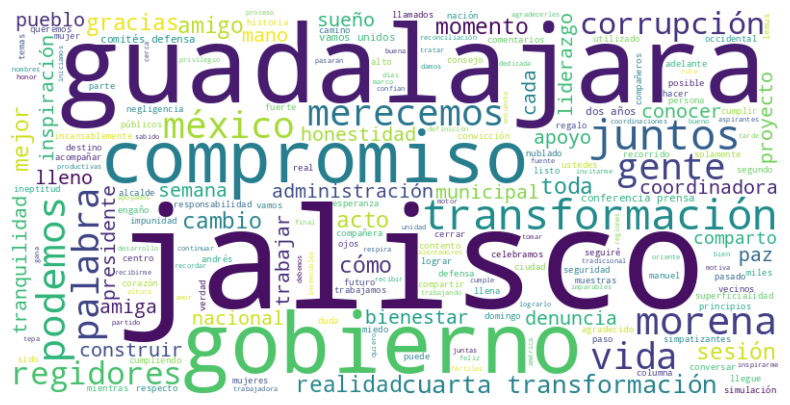

In [16]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.show()

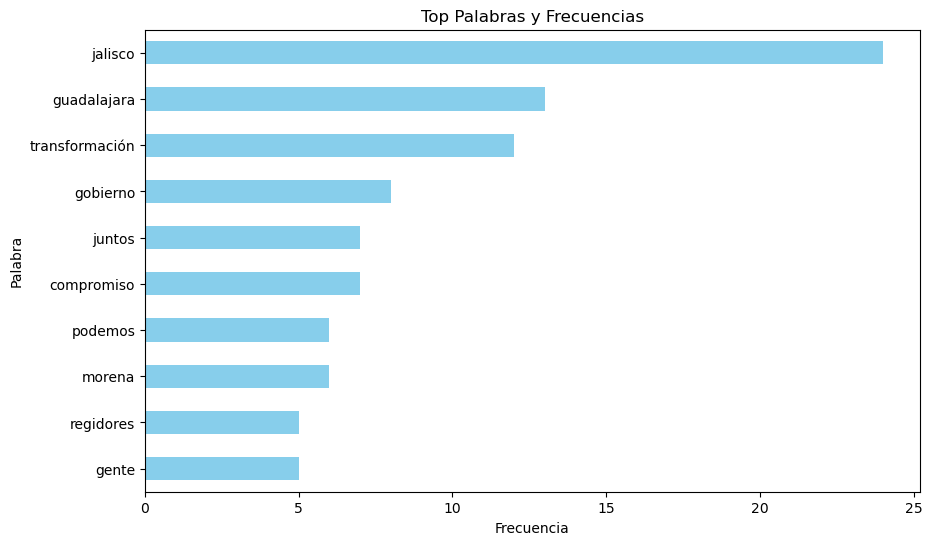

In [17]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()

In [33]:
tweets_tidy.tokens

0     [para, que, la, transformación, llegue, a, jal...
1     [en, tepa, y, todos, los, altos, hay, gente, t...
2                     [twclid219wqod8qtgqv6e93zaurs7wm]
3     [conocer, de, cerca, a, la, gente, y, sus, his...
4     [en, el, oriente, de, guadalajara, y, en, todo...
                            ...                        
59    [solamente, desde, la, honestidad, podemos, co...
60    [han, sido, dos, años, de, un, gobierno, en, g...
61    [esta, mañana, participé, en, la, tercera, ses...
62    [listo, para, acompañar, a, nuestra, compañera...
63    [mi, recorrido, por, el, estado, refuerza, mi,...
Name: tokens, Length: 64, dtype: object

In [34]:
texts = tweets_tidy.tokens

punctuation = set(string.punctuation)

texts = [[word for word in doc if word not in stop_words and word not in punctuation] for doc in texts]

# Crear un diccionario de términos a partir del corpus
dictionary = corpora.Dictionary(texts)

# Crear una representación vectorial del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
# Entrenar el modelo LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.016*"transformación" + 0.016*"defensa" + 0.012*"cuarta" + 0.012*"compromiso" + 0.012*"coordinadora" + 0.009*"sesión" + 0.009*"comparto" + 0.009*"vida" + 0.009*"comités" + 0.009*"columna"')
(1, '0.012*"gobierno" + 0.011*"compromiso" + 0.011*"semana" + 0.008*"amigo" + 0.008*"años" + 0.008*"presidente" + 0.008*"vida" + 0.008*"duda" + 0.008*"andrés" + 0.008*"manuel"')
(2, '0.025*"jalisco" + 0.021*"guadalajara" + 0.014*"regidores" + 0.011*"morena" + 0.011*"corrupción" + 0.011*"actos" + 0.008*"denuncia" + 0.008*"transformación" + 0.008*"méxico" + 0.008*"apoyo"')
(3, '0.029*"jalisco" + 0.015*"vamos" + 0.012*"juntos" + 0.009*"transformación" + 0.009*"tranquilidad" + 0.009*"cambio" + 0.009*"unidos" + 0.006*"merecemos" + 0.006*"bienestar" + 0.006*"paz"')
(4, '0.018*"guadalajara" + 0.015*"jalisco" + 0.011*"podemos" + 0.011*"realidad" + 0.008*"merecemos" + 0.008*"prensa" + 0.008*"conferencia" + 0.008*"mejor" + 0.008*"gracias" + 0.008*"amiga"')


In [21]:
print(topics)

[(0, '0.016*"transformación" + 0.016*"defensa" + 0.012*"cuarta" + 0.012*"compromiso" + 0.012*"coordinadora" + 0.009*"sesión" + 0.009*"comparto" + 0.009*"vida" + 0.009*"comités" + 0.009*"columna"'), (1, '0.012*"gobierno" + 0.011*"compromiso" + 0.011*"semana" + 0.008*"amigo" + 0.008*"años" + 0.008*"presidente" + 0.008*"vida" + 0.008*"duda" + 0.008*"andrés" + 0.008*"manuel"'), (2, '0.025*"jalisco" + 0.021*"guadalajara" + 0.014*"regidores" + 0.011*"morena" + 0.011*"corrupción" + 0.011*"actos" + 0.008*"denuncia" + 0.008*"transformación" + 0.008*"méxico" + 0.008*"apoyo"'), (3, '0.029*"jalisco" + 0.015*"vamos" + 0.012*"juntos" + 0.009*"transformación" + 0.009*"tranquilidad" + 0.009*"cambio" + 0.009*"unidos" + 0.006*"merecemos" + 0.006*"bienestar" + 0.006*"paz"'), (4, '0.018*"guadalajara" + 0.015*"jalisco" + 0.011*"podemos" + 0.011*"realidad" + 0.008*"merecemos" + 0.008*"prensa" + 0.008*"conferencia" + 0.008*"mejor" + 0.008*"gracias" + 0.008*"amiga"')]


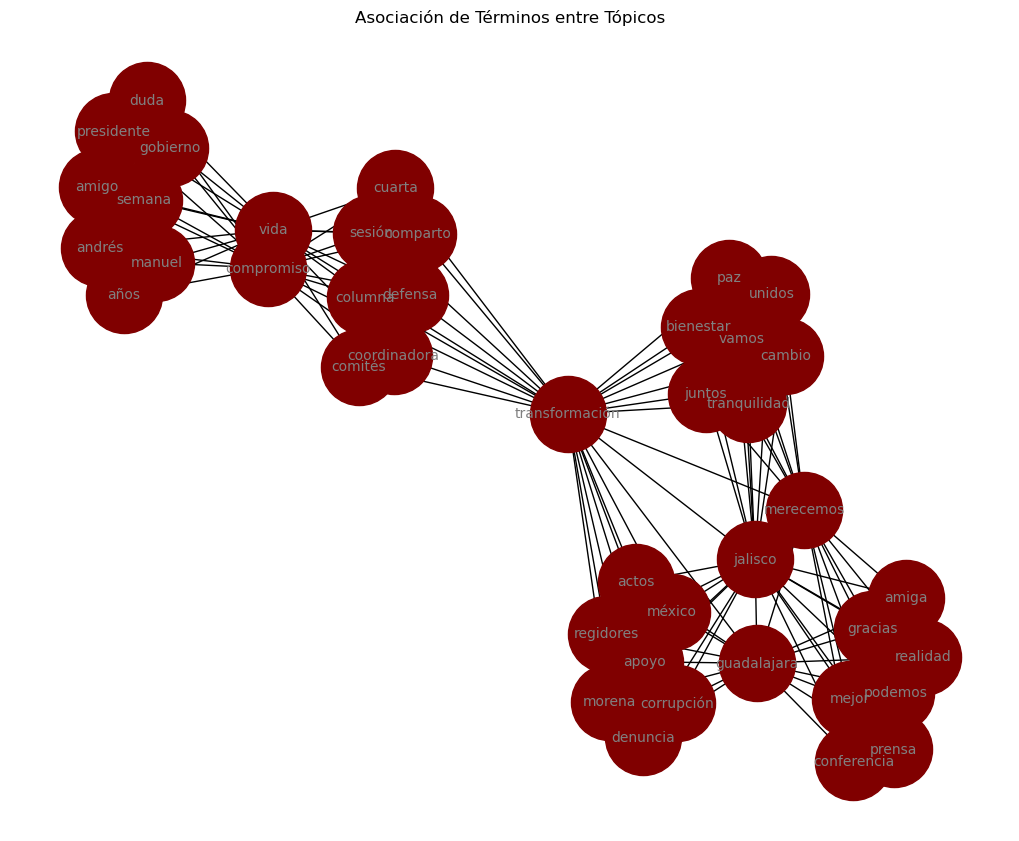

In [22]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

# Opción 2 Topicos

In [23]:
tweets_tidy

,texto,tokens
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo..."
...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera..."


In [24]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
tweets_tidy['texto_preprocesado'] = tweets_tidy.texto.apply(preprocess_text)
tweets_tidy

,texto,tokens,texto_preprocesado
0,para que la transformación llegue a jalisco de...,"[para, que, la, transformación, llegue, a, jal...","[transformación, llegar, jalisco, deber, cumpl..."
1,en tepa y todos los altos hay gente trabajador...,"[en, tepa, y, todos, los, altos, hay, gente, t...","[tepa, alto, gente, trabajador, dedicado, apoy..."
2,twclid219wqod8qtgqv6e93zaurs7wm,[twclid219wqod8qtgqv6e93zaurs7wm],[]
3,conocer de cerca a la gente y sus historias me...,"[conocer, de, cerca, a, la, gente, y, sus, his...","[cerca, gente, historia, motivar, llenar, vida..."
4,en el oriente de guadalajara y en todo jalisco...,"[en, el, oriente, de, guadalajara, y, en, todo...","[oriente, guadalajara, jalisco, respirar, fuer..."
...,...,...,...
59,solamente desde la honestidad podemos construi...,"[solamente, desde, la, honestidad, podemos, co...","[honestidad, construir, realidad, realidad, bi..."
60,han sido dos años de un gobierno en guadalajar...,"[han, sido, dos, años, de, un, gobierno, en, g...","[año, gobierno, guadalajara, lleno, corrupción..."
61,esta mañana participé en la tercera sesión ord...,"[esta, mañana, participé, en, la, tercera, ses...","[mañana, participé, sesión, ordinario, entrega..."
62,listo para acompañar a nuestra compañera en el...,"[listo, para, acompañar, a, nuestra, compañera...","[listo, acompañar, compañera, consejo, naciona..."


In [25]:
from gensim import corpora

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(tweets_tidy['texto_preprocesado'])

# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in tweets_tidy['texto_preprocesado']]

In [26]:
from gensim.models import LdaModel

num_topics = 5  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [27]:
# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.021*"trabajar" + 0.017*"guadalajara" + 0.017*"seguir" + 0.017*"junto" + 0.017*"corrupción" + 0.014*"jalisco" + 0.012*"compromiso" + 0.012*"confiar" + 0.012*"denuncia" + 0.012*"hacer"')
(1, '0.016*"jalisco" + 0.010*"compromiso" + 0.010*"junto" + 0.010*"amigo" + 0.010*"gobierno" + 0.010*"transformación" + 0.010*"guadalajara" + 0.007*"cumplir" + 0.007*"gente" + 0.007*"apoyo"')
(2, '0.015*"vida" + 0.015*"público" + 0.015*"guadalajara" + 0.010*"acompañar" + 0.010*"gente" + 0.010*"nacional" + 0.010*"compartir" + 0.010*"utilizar" + 0.010*"camino" + 0.010*"incansablemente"')
(3, '0.015*"dra" + 0.015*"defensa" + 0.015*"transformación" + 0.015*"cuarto" + 0.015*"coordinadora" + 0.010*"palabra" + 0.010*"año" + 0.010*"gobierno" + 0.010*"compartir" + 0.010*"inspiración"')
(4, '0.049*"jalisco" + 0.013*"transformación" + 0.010*"realidad" + 0.010*"mano" + 0.007*"morena" + 0.007*"tener" + 0.007*"merec" + 0.007*"honestidad" + 0.007*"tranquilidad" + 0.007*"proyecto"')


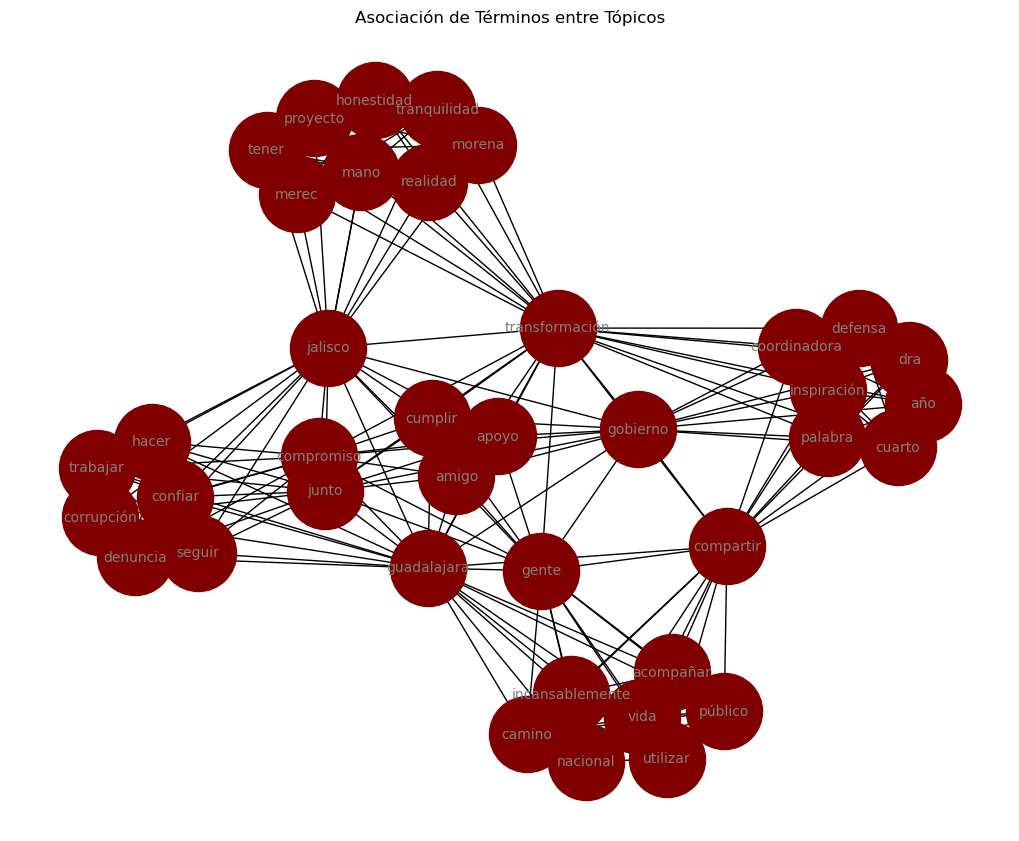

In [28]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [107]:
import pandas as pd
import spacy
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_posts_clean['bigramas_spacy'] = df_posts_clean['texto'].apply(generar_bigramas_spacy)

# Generación de bigramas con NLTK
def generar_bigramas_nltk(texto):
    tokens = word_tokenize(texto)
    bigramas = list(ngrams(tokens, 3))
    return bigramas

df_posts_clean['bigramas_nltk'] = df_posts_clean['texto'].apply(generar_bigramas_nltk)

# Visualización del DataFrame resultante
df_posts_clean


,texto,texto2,texto_lematizado,bigramas_spacy,bigramas_nltk
0,para que la transformación llegue a jalisco de...,,para que el transformación llegar a jalisco de...,"[(para, que), (que, la), (la, transformación),...","[(para, que, la), (que, la, transformación), (..."
1,en tepa y todos los altos hay gente trabajador...,,en tepa y todo el alto haber gente trabajador ...,"[(en, tepa), (tepa, y), (y, todos), (todos, lo...","[(en, tepa, y), (tepa, y, todos), (y, todos, l..."
2,twclid219wqod8qtgqv6e93zaurs7wm,,twclid219wqod8qtgqv6e93zaurs7wm,[],[]
3,conocer de cerca a la gente y sus historias me...,,conocer de cerca a el gente y su historia yo m...,"[(conocer, de), (de, cerca), (cerca, a), (a, l...","[(conocer, de, cerca), (de, cerca, a), (cerca,..."
4,en el oriente de guadalajara y en todo jalisco...,,en el oriente de guadalajara y en todo jalisco...,"[(en, el), (el, oriente), (oriente, de), (de, ...","[(en, el, oriente), (el, oriente, de), (orient..."
...,...,...,...,...,...
59,solamente desde la honestidad podemos construi...,,solamente desde el honestidad poder construir ...,"[(solamente, desde), (desde, la), (la, honesti...","[(solamente, desde, la), (desde, la, honestida..."
60,han sido dos años de un gobierno en guadalajar...,no descansaremos hasta que…,haber ser dos año de uno gobierno en guadalaja...,"[(han, sido), (sido, dos), (dos, años), (años,...","[(han, sido, dos), (sido, dos, años), (dos, añ..."
61,esta mañana participé en la tercera sesión ord...,", donde se entregó la constancia que acredita ...",este mañana participé en el tercero sesión ord...,"[(esta, mañana), (mañana, participé), (partici...","[(esta, mañana, participé), (mañana, participé..."
62,listo para acompañar a nuestra compañera en el...,en el Consejo Nacional de MORENA!,listo para acompañar a nuestro compañera en el...,"[(listo, para), (para, acompañar), (acompañar,...","[(listo, para, acompañar), (para, acompañar, a..."


In [133]:
from nltk.collocations import *

flatten_corpus = [w for l in df_posts_clean.bigramas_spacy for w in l]

treshold = 4

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]


In [190]:
bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(1)
colocaciones = finder.nbest(bigram_measure.pmi, 10)

In [191]:
colocaciones

[('actual', 'alcalde'),
 ('asociación', 'civil'),
 ('beneficio', 'personal'),
 ('brecha', 'salarial'),
 ('bueno', 'recordar'),
 ('carácter', 'comprensivo'),
 ('contraloría', 'ciudadana'),
 ('corazón', 'encendido'),
 ('cuáles', 'reconocen'),
 ('delfina', 'gómez')]

In [170]:
import pandas as pd
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_posts_clean['texto_lematizado'] = df_posts_clean['texto'].apply(lematizar_texto)

# Visualización del DataFrame resultante
df_posts_clean

,texto,texto2,texto_lematizado,bigramas_spacy,bigramas_nltk,texto_preprocesado
0,para que la transformación llegue a jalisco de...,,para que el transformación llegar a jalisco de...,"[(para, que), (que, la), (la, transformación),...","[(para, que, la), (que, la, transformación), (...","[transformación, llegar, jalisco, deber, cumpl..."
1,en tepa y todos los altos hay gente trabajador...,,en tepa y todo el alto haber gente trabajador ...,"[(en, tepa), (tepa, y), (y, todos), (todos, lo...","[(en, tepa, y), (tepa, y, todos), (y, todos, l...","[tepa, alto, gente, trabajador, dedicado, apoy..."
2,twclid219wqod8qtgqv6e93zaurs7wm,,twclid219wqod8qtgqv6e93zaurs7wm,[],[],[]
3,conocer de cerca a la gente y sus historias me...,,conocer de cerca a el gente y su historia yo m...,"[(conocer, de), (de, cerca), (cerca, a), (a, l...","[(conocer, de, cerca), (de, cerca, a), (cerca,...","[cerca, gente, historia, motivar, llenar, vida..."
4,en el oriente de guadalajara y en todo jalisco...,,en el oriente de guadalajara y en todo jalisco...,"[(en, el), (el, oriente), (oriente, de), (de, ...","[(en, el, oriente), (el, oriente, de), (orient...","[oriente, guadalajara, jalisco, respirar, fuer..."
...,...,...,...,...,...,...
59,solamente desde la honestidad podemos construi...,,solamente desde el honestidad poder construir ...,"[(solamente, desde), (desde, la), (la, honesti...","[(solamente, desde, la), (desde, la, honestida...","[honestidad, construir, realidad, realidad, bi..."
60,han sido dos años de un gobierno en guadalajar...,no descansaremos hasta que…,haber ser dos año de uno gobierno en guadalaja...,"[(han, sido), (sido, dos), (dos, años), (años,...","[(han, sido, dos), (sido, dos, años), (dos, añ...","[año, gobierno, guadalajara, lleno, corrupción..."
61,esta mañana participé en la tercera sesión ord...,", donde se entregó la constancia que acredita ...",este mañana participé en el tercero sesión ord...,"[(esta, mañana), (mañana, participé), (partici...","[(esta, mañana, participé), (mañana, participé...","[mañana, participé, sesión, ordinario, entrega..."
62,listo para acompañar a nuestra compañera en el...,en el Consejo Nacional de MORENA!,listo para acompañar a nuestro compañera en el...,"[(listo, para), (para, acompañar), (acompañar,...","[(listo, para, acompañar), (para, acompañar, a...","[listo, acompañar, compañera, consejo, naciona..."


In [193]:
# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts_clean['texto_preprocesado'] = df_posts_clean['texto_lematizado'].apply(preprocess_text)

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(df_posts_clean['texto_preprocesado'])
dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario


# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts_clean['texto_preprocesado']]

num_topics = 8  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.031*"jalisco" + 0.022*"gobierno" + 0.022*"transformación" + 0.014*"guadalajara" + 0.014*"año" + 0.014*"corrupción" + 0.014*"mano" + 0.014*"pueblo" + 0.014*"mujer" + 0.014*"momento"')
(1, '0.042*"transformación" + 0.034*"defensa" + 0.025*"compartir" + 0.025*"dra" + 0.025*"cuarto" + 0.025*"coordinadora" + 0.017*"comités" + 0.017*"occidental" + 0.017*"columna" + 0.017*"contento"')
(2, '0.024*"guadalajara" + 0.017*"morena" + 0.017*"nublado" + 0.017*"compañera" + 0.017*"consejo" + 0.017*"público" + 0.017*"utilizar" + 0.009*"lograr" + 0.009*"sesión" + 0.009*"compañero"')
(3, '0.022*"jalisco" + 0.018*"seguir" + 0.018*"trabajar" + 0.018*"acto" + 0.018*"compromiso" + 0.018*"cumplir" + 0.012*"palabra" + 0.012*"méxico" + 0.012*"apoyo" + 0.012*"mil"')
(4, '0.020*"semana" + 0.010*"momento" + 0.010*"palabra" + 0.010*"honestidad" + 0.010*"cerrar" + 0.010*"querer" + 0.010*"regalo" + 0.010*"vida" + 0.010*"amiga" + 0.010*"responsabilidad"')
(5, '0.038*"jalisco" + 0.016*"realidad" + 0.016*"unir" +

In [166]:
topics[0]

(0,
 '0.016*"gente" + 0.012*"vida" + 0.012*"acto" + 0.012*"apoyo" + 0.012*"jalisco" + 0.008*"lograr" + 0.008*"construir" + 0.008*"realidad" + 0.008*"acompañar" + 0.008*"vecino"')

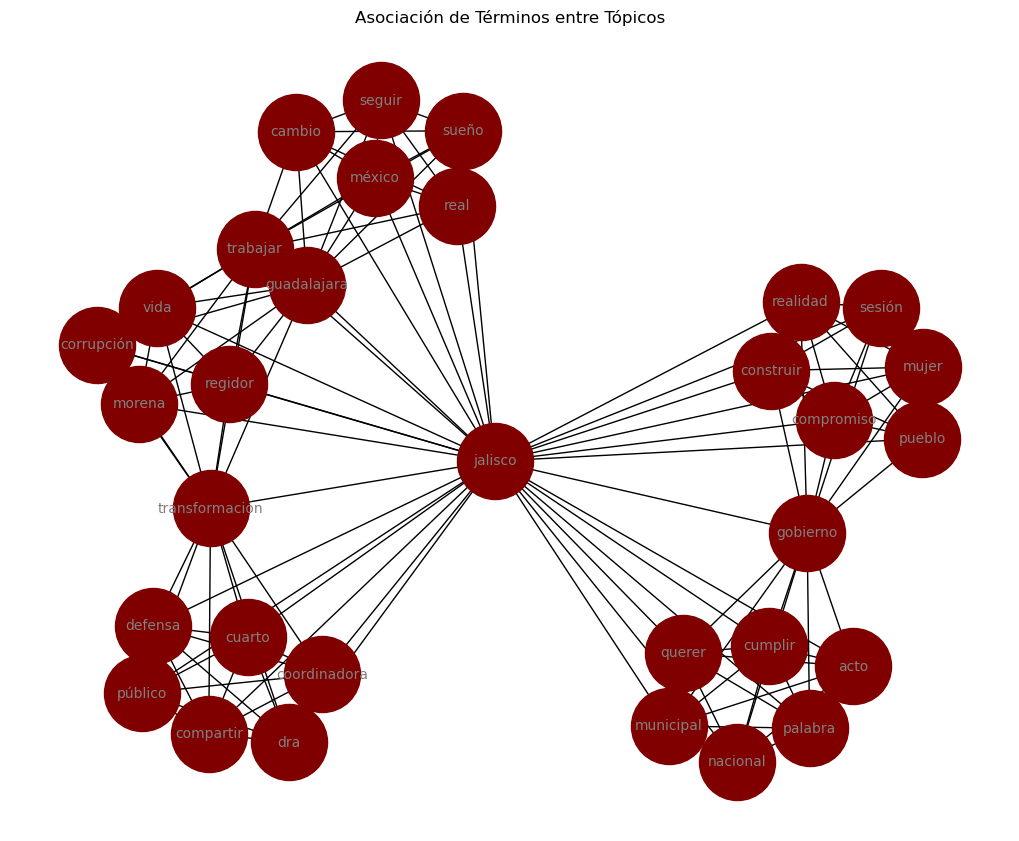

In [172]:
# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [173]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Genera la visualización de LDA
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Visualiza los tópicos
pyLDAvis.display(lda_display)


In [192]:
topics = lda_model.print_topics(num_words=15)  

topic_data = []
for topic_id, topic in topics:
    topic_words = [word.split('*')[1] for word in topic.split('+')]
    topic_data.append([topic_id, ", ".join(topic_words)])

# DataFrame a partir de los datos de tópicos
df_topics = pd.DataFrame(topic_data, columns=["ID de Tópico", "Palabras Clave"])
print(df_topics)

   ID de Tópico                                     Palabras Clave
0             0  "jalisco" , "compromiso" , "mujer" , "gobierno...
1             1  "guadalajara" , "transformación" , "corrupción...
2             2  "gobierno" , "palabra" , "jalisco" , "querer" ...
3             3  "transformación" , "jalisco" , "defensa" , "dr...
4             4  "jalisco" , "guadalajara" , "trabajar" , "camb...


In [162]:
import networkx as nx
import plotly.graph_objects as go

# Crear un grafo de NetworkX
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Obtener las posiciones de los nodos en el gráfico
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Extraer las posiciones X e Y de los nodos
pos_x = {node: pos[node][0] for node in G.nodes}
pos_y = {node: pos[node][1] for node in G.nodes}

# Crear un objeto de grafo de Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos_x[edge[0]], pos_y[edge[0]]
    x1, y1 = pos_x[edge[1]], pos_y[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = list(pos_x.values())
node_y = list(pos_y.values())

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(thickness=15, title='Node Connections'),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# de conexiones: ' + str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Crear la figura de Plotly
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0, l=0, r=0, t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# Mostrar la figura
fig.update_layout(title='Asociación de Términos entre Tópicos', title_x=0.5)
fig.show()


In [163]:
# Crear un conjunto de términos únicos
unique_terms = set()
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    unique_terms.update(terms)

# Crear listas para nodos y enlaces
nodes = list(unique_terms)
source_indices = []
target_indices = []
values = []

# Procesar los tópicos y sus palabras clave para identificar las conexiones
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    for term in terms:
        source_indices.append(nodes.index(term))
        target_indices.append(len(nodes) + topic_id)  # Cada tema se representa como un nodo adicional
        values.append(1)

# Crear un diagrama de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Etiquetas de los términos
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

# Mostrar el diagrama de Sankey
fig.update_layout(title_text="Diagrama de Sankey de Tópicos y Términos")
fig.show()

# Análisis de Sentimientos

In [116]:
from sentiment_analysis_spanish import sentiment_analysis

sentiment = sentiment_analysis.SentimentAnalysisSpanish()

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [117]:
# Cálculo de la Polaridad 

def polaridad(texto):
    sentiment = sentiment_analysis.SentimentAnalysisSpanish()
    return sentiment.sentiment(texto)

In [119]:
df_posts_clean["polaridad"] = df_posts_clean["texto"].apply(polaridad)

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/usr/lib64/python3.11/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [120]:
df_posts_clean

,texto,texto2,bigramas_spacy,bigramas_nltk,texto_lematizado,texto_preprocesado,polaridad
0,para que la transformación llegue a jalisco de...,,"[(para, que), (que, la), (la, transformación),...","[(para, que), (que, la), (la, transformación),...",para que el transformación llegar a jalisco de...,"[transformación, llegar, jalisco, deber, cumpl...",2.117803e-03
1,en tepa y todos los altos hay gente trabajador...,,"[(en, tepa), (tepa, y), (y, todos), (todos, lo...","[(en, tepa), (tepa, y), (y, todos), (todos, lo...",en tepa y todo el alto haber gente trabajador ...,"[tepa, alto, gente, trabajador, dedicado, apoy...",1.686473e-03
2,twclid219wqod8qtgqv6e93zaurs7wm,,[],[],twclid219wqod8qtgqv6e93zaurs7wm,[],4.978923e-01
3,conocer de cerca a la gente y sus historias me...,,"[(conocer, de), (de, cerca), (cerca, a), (a, l...","[(conocer, de), (de, cerca), (cerca, a), (a, l...",conocer de cerca a el gente y su historia yo m...,"[cerca, gente, historia, motivar, llenar, vida...",1.856251e-03
4,en el oriente de guadalajara y en todo jalisco...,,"[(en, el), (el, oriente), (oriente, de), (de, ...","[(en, el), (el, oriente), (oriente, de), (de, ...",en el oriente de guadalajara y en todo jalisco...,"[oriente, guadalajara, jalisco, respirar, fuer...",1.182428e-04
...,...,...,...,...,...,...,...
59,solamente desde la honestidad podemos construi...,,"[(solamente, desde), (desde, la), (la, honesti...","[(solamente, desde), (desde, la), (la, honesti...",solamente desde el honestidad poder construir ...,"[honestidad, construir, realidad, realidad, bi...",4.986227e-03
60,han sido dos años de un gobierno en guadalajar...,no descansaremos hasta que…,"[(han, sido), (sido, dos), (dos, años), (años,...","[(han, sido), (sido, dos), (dos, años), (años,...",haber ser dos año de uno gobierno en guadalaja...,"[año, gobierno, guadalajara, lleno, corrupción...",2.059359e-08
61,esta mañana participé en la tercera sesión ord...,", donde se entregó la constancia que acredita ...","[(esta, mañana), (mañana, participé), (partici...","[(esta, mañana), (mañana, participé), (partici...",este mañana participé en el tercero sesión ord...,"[mañana, participé, sesión, ordinario, entrega...",4.750532e-03
62,listo para acompañar a nuestra compañera en el...,en el Consejo Nacional de MORENA!,"[(listo, para), (para, acompañar), (acompañar,...","[(listo, para), (para, acompañar), (acompañar,...",listo para acompañar a nuestro compañera en el...,"[listo, acompañar, compañera, consejo, naciona...",2.103488e-01


In [155]:
import numpy as np
mediana = np.median(df_posts_clean.polaridad)
df_posts_clean.polaridad.describe()

count    6.400000e+01
mean     1.105412e-01
std      2.328213e-01
min      1.234257e-10
25%      6.155308e-05
50%      1.720410e-03
75%      5.061731e-02
max      9.698579e-01
Name: polaridad, dtype: float64

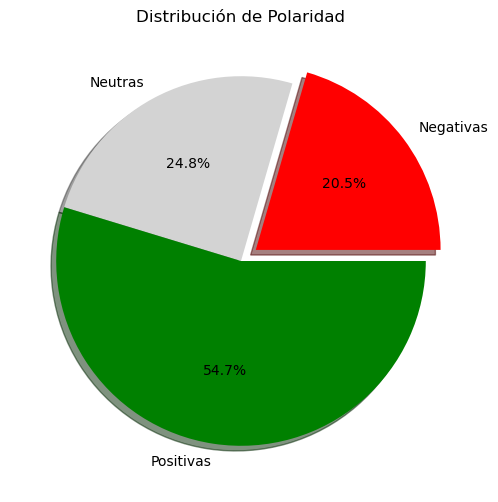

In [157]:
# Clasificar las polaridades en negativas, neutras y positivas
negativas = df_posts_clean[(df_posts_clean['polaridad'] < mediana/4)]
neutras = df_posts_clean[(df_posts_clean['polaridad'] < mediana/2) & (df_posts_clean['polaridad'] <= 0.08)]
positivas = df_posts_clean[(df_posts_clean['polaridad'] < 9.698579e-01)]


# Contar cuántos elementos hay en cada categoría
num_negativas = len(negativas)
num_neutras = len(neutras)
num_positivas = len(positivas)

# Crear la gráfica de pastel
labels = ['Negativas', 'Neutras', 'Positivas']
sizes = [num_negativas, num_neutras, num_positivas]
colors = ['red', 'lightgray', 'green']
explode = (0.1, 0, 0)  # Para resaltar la categoría de negativas

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True)
plt.title('Distribución de Polaridad')
plt.show()

In [171]:
from collections import defaultdict
from gensim import corpora

documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

print(texts)

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]
